## Monte Carlo Simulation using Geometric Brownian Motion
### By Hitaansh Gaur

$\newcommand{\E}{\mathrm{E}}$
$\newcommand{\e}{\mathrm{e}}$
$\newcommand{\drm}{\mathrm{\, d}}$
$\newcommand{\var}{\mathrm{var}}$
$\newcommand{\cov}{\mathrm{cov}}$
$\newcommand{\stdev}{\mathrm{stdev}}$
$\newcommand{\sm}{ {\scriptstyle{*}} }$
$\renewcommand{\mm}{{\scriptsize @}}$
$\renewcommand{\t}{^{\mathsf{T}}}$
$\renewcommand{\comma}{\, , \,}$
$\renewcommand{\vec}[1]{\mathbf{#1}}$

In [13]:
# Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

We wil be considering a hypothetical stock market portfolio whose value follows Geometric Brownian Motion. We are assuming the continuously compounded real rate of interest is $r_\text{real}=0.87$% per year, and the continuously compounded inflation rate is $i = 2.87$% per year, the continuously compounded risk premium is $\pi = 6.26$% per year, and the annualized standard deviation of log returns is $\sigma = 15.91$%.

How did we get these numbers? They were obtained from the file "100YearSummary.ipynb" in the S&P Experiment Project where we did analysis on 100 years of both S&P and Bond data. 

Lets first see what the expected nominal value of one dollar will be after a certain number of years. We will compare this to the the real returns.

In [17]:
# assuptions cell, cc = continously compounded
cc_real_rate = .0087
cc_inflation_rate = .0287
cc_risk_premium = .0626
annualized_std_log_returns = .1591

In [15]:
years = [1,2,5,10,20,30,100]
expected_values = np.exp((cc_real_rate + cc_inflation_rate + cc_risk_premium) * np.array(years)) # Calculating the expected nominal value

df = pd.DataFrame({
    'Years': years,
    'Expected Nominal Value': expected_values
})
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
display(df)

,Years,Expected Nominal Value
0,1,1.105
1,2,1.221
2,5,1.649
3,10,2.718
4,20,7.389
5,30,20.086
6,100,"22,026.466"


These values make sense here. The "nominal" returns include inflation so the $\sigma^2/2$ adjustment is not relevant here (we need this adjustment for Geometric Brownian Motion).

B. Simulate $N=5000$ sample paths of monthly returns over 100 years. (Hint: If you simulate a Brownian motion and then exponentiate it, remember to adjust the mean of the Brownian motion down by $\frac{\sigma^2}{2} \sm \Delta t$ to make the sample mean of the geometric Brownian motion correct.) 

   1. Along each of the $N$ sample paths, calculate the following statistics: sample mean of nominal monthly gross returns, sample variance of nominal gross monthly returns, sample mean of nominal monthly log returns, and sample variance of nominal monthly log returns over the first 1, 2, 5, 10, 20, 30, 100 years.

   2. Calculate the sample means and sample standard deviations of the $N$ observations for these four statistics over the the 7 time periods. Display a dataframe comparing the sample means and standard deviations of these four statistics with the predicted mean of these four statistics.

   3. What fraction of the portfolios are expected to beat the expected return? What fraction of the portfolios actually beat the expected return? Explain why these fractions are not one half.

Now, let us simulate some same paths of monthly returns over 100 years. What model will we use to simulate? We will use Geometric Brownian Motion while looking at  $N=5000$ sample paths of monthly returns over 100 years. To do this, we will simulate Brownian motion and then exponentiate it, while remembering to adjust the mean of the Brownian motion down by $\frac{\sigma^2}{2} \sm \Delta t$ to make the sample mean of the geometric Brownian motion correct.

In [18]:
def fgmb(mu, sigma, shape, dt, rng, p0=1.00, p0_first=True, dtype=np.float64):
    """
    Simulate paths for geometric brownian motion.

    Usage:
    
    mu = expected return (per year), not continuously compounded,
         e.g. mu=)0.10 means 10 percent expected return.
    sigma = log (Black-Scholes) volatility (annualized)
    shape = (npaths, nobs), where paths = number of paths, nob = numbe of observations per path.
    dt = time interval (e.g., dt = 1/12 means monthly observations)
    rng = numpy random number generator, e.g. rng = np.random.default_rng(1234). 
    
    output = n+1 x m matrix or n x m matrix, where each of the m columums is a geometric brownian motion path
    starting with a value of p0. Length n or n+1 depends on whether start is included
    
    Notes: 
    
    1. No default argument for rng because one generally wants to use the same rng
    on different function calls to avoid creating correlated paths across different
    function calls!
    
    2. Base time period can be anything, but would typically be annual. 
    The argument dt is a fraction of the based time period.
    
    3. The parameter mu is the mean of the gbm, not the mean of the log of the gbm.
    
    """
    
    res = np.exp((rng.standard_normal(shape, dtype=dtype) * (sigma * np.sqrt(dt)) 
                  + (np.log(1 + mu) - 0.50 * sigma**2) * dt).cumsum(axis=1) + np.log(p0))
    
    if p0_first == True:
        res = np.hstack([np.full((shape[0], 1), p0, dtype=dtype), res])
        
    return res   

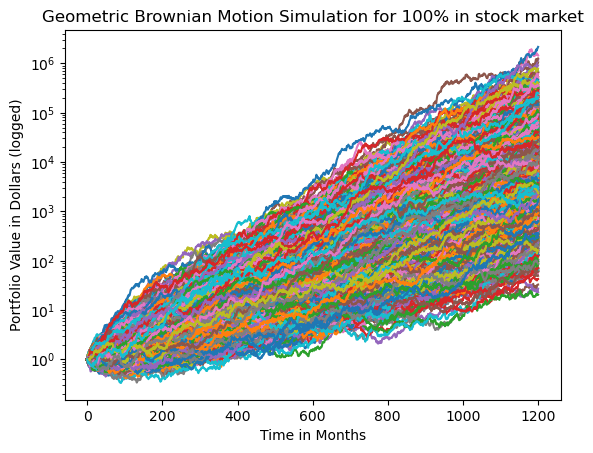

In [20]:
rbar_per_year = cc_real_rate + cc_inflation_rate + cc_risk_premium
sigma = annualized_std_log_returns
mu = np.exp(rbar_per_year) - 1
dt = 1.00 / 12.00
nobs = 1200
npaths = 5000
p0 = 1
dtype = np.float64
rng = np.random.default_rng(1234)
shape = (npaths, nobs)

p = fgmb(mu, sigma, shape, dt, rng, p0, p0_first=True, dtype=dtype)
t = (np.array(np.ones_like(p[0, :])).cumsum() - 1)
plt.plot(t, p.T)
plt.title("Geometric Brownian Motion Simulation for 100% in stock market")
plt.xlabel('Time in Months')
plt.ylabel('Portfolio Value in Dollars (logged)')
plt.yscale('log')
plt.show()

In [32]:
print(f"The average final value of the portoflio was: ${np.log(np.average(p.T[-1]))} ")

The average final value of the portoflio was: $10.04246064966021 


So what do we learn from the above simulation? That if invest our money fully into the value weighted S&P 500, over 100 years we can expect about a 1000% return! That is a lot of growth - clearly the stock market has done very well over the last 100 years.

Now let us consider another scenario. Consider an investor who allocates his wealth between the stock market portfolio and a riskfree money market fund earning the real rate plus inflation rate every year. The investor chooses a fixed target fraction of wealth to invest in the equity portfolio. At the end of each month, the investor trades to rebalance the portfolio so that it holds the target fractions in the stock portfolio and the money market fund at the beginning of the next month. Assume that the investor has log utility. As an approximation, this means that the investor chooses the fraction $\alpha$ to invest in stocks to maximize the function $\mu(\alpha) - \tfrac{1}{2} \sm \rho \sm \sigma^2(\alpha)$, where $\mu(\alpha)$ is the expected continuously compounded return on the stock market portfolio, $\sigma^2(\alpha)$ is the variance of log returns on the portfolio, and $\rho=1$ for log utility.

The first thing I want to show is that $\mu(\alpha)$ is a simple linear function of $\alpha$, $\sigma^2(\alpha)$ is a simple quadratic function of $\alpha$, and the optimal value of $\alpha$ is $1.50$. Therefore, the optimizing investor invests 150 percent of his wealth in the stock market portfolio and finances this by borrowing 50 percent of the portfolio at the risk-free rate. I also want to show that the probability of the optimizing investor earning a portfolio return of $-100$ percent in one month is small enough that we might be justified in ignoring it.